In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from env import get_connection
from prepare import train_val_test
import acquire
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [12]:
def telco_prep(df):
    df = acquire.get_telco_data(get_connection)
    df = df.drop(['Unnamed: 0','gender', 'senior_citizen', 'partner', 'phone_service', 'tech_support', 'streaming_tv', 
                    'streaming_movies', 'paperless_billing', 'internet_service_type', 'online_security', 'online_backup', 
                    'device_protection', 'internet_service_type_id', 'customer_id', 'multiple_lines'], axis =1)
    df = df.dropna()
    df['total_charges'] = df['total_charges'].replace(' ', 0).astype(float)
    
    return df

In [14]:
telco = telco_prep('df')
telco.head()

,payment_type_id,contract_type_id,dependents,tenure,monthly_charges,total_charges,churn,contract_type,payment_type
0,2,2,Yes,9,65.6,593.30,No,One year,Mailed check
1,2,1,No,9,59.9,542.40,No,Month-to-month,Mailed check
2,1,1,No,4,73.9,280.85,Yes,Month-to-month,Electronic check
3,1,1,No,13,98.0,1237.85,Yes,Month-to-month,Electronic check
4,2,1,No,3,83.9,267.40,Yes,Month-to-month,Mailed check


In [19]:
def chi2(column, df):
    chi2, p, degf, expected = chi2, p, degf, expected = stats.chi2_contingency(pd.crosstab(df['churn'], df[column]))
    if p <= .05:
        print(f'Comparing relationship between churn and {column}')
        print(chi2, p)
        print('------------------')
        
# Using a chi2 test to determine the main drivers behind the churn at Telco 
# Does not include payments yet, have to drop na and make a seperate test below

In [20]:
chi2('contract_type_id', telco)

Comparing relationship between churn and contract_type_id
1184.5965720837926 5.863038300673391e-258
------------------


In [21]:
def t_test(column, df):
    churn = df[df['churn'] == 'Yes'][column]
    not_churned = df[df['churn'] == 'No'][column]
    t, p = stats.ttest_ind(churn, not_churned, equal_var = False)
    print(f'Comparing relationship between churn and {column}')
    print(t, p)
    print('------------------')

# T test for the charges because they we are comparing a catagorical variable to a continuous one
# The code will print the results in a similar format to the chi2 test above

In [22]:
t_test('monthly_charges', telco)

Comparing relationship between churn and monthly_charges
18.407526676414673 8.59244933154705e-73
------------------


In [28]:
def split_data(df, target):
    train, val, test = train_val_test(df, target)
    
    X_train = train.drop(columns='churn')
    y_train = train['churn']

    X_val = val.drop(columns='churn')
    y_val = val['churn']

    X_test = test.drop(columns='churn')
    y_test = test['churn']
    
    return train, val, test, X_train, y_train, X_val, y_val, X_test, y_test
# Creating splits for the data using custom libraray function

In [29]:
train, validate, test, X_train, y_train, X_val, y_val, X_test, y_test = split_data(telco, 'churn')

In [30]:
train.head()

,payment_type_id,contract_type_id,dependents,tenure,monthly_charges,total_charges,churn,contract_type,payment_type
5609,1,1,No,14,76.45,1117.55,No,Month-to-month,Electronic check
2209,2,2,No,5,70.00,347.40,Yes,One year,Mailed check
6919,1,1,No,35,75.20,2576.20,Yes,Month-to-month,Electronic check
2284,1,3,No,58,86.10,4890.50,No,Two year,Electronic check
845,2,1,No,2,49.60,114.70,Yes,Month-to-month,Mailed check


In [35]:
def contract_plot(df, x, hue):
    sns.countplot(x = df[x], hue = df[hue])
# count plot for contract_type hued by churn to visualize churn for each contract type

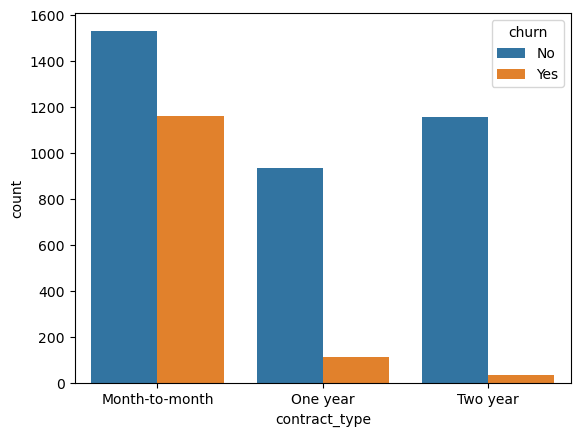

In [36]:
contract_plot(train, 'contract_type', 'churn')

In [40]:
def dependents_plot(df, x, hue):
    sns.countplot(x = df[x], hue = df[hue])
# Countplot for dependents hued by churn

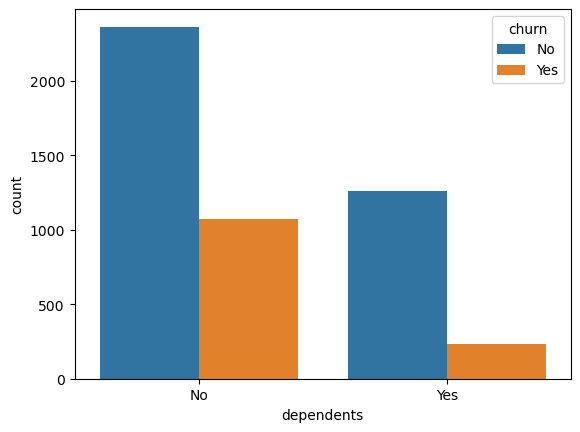

In [41]:
dependents_plot(train, 'dependents', 'churn')

In [37]:
def payment_plot(df, y, hue):
    sns.countplot(y = df[y], hue = df[hue])
# Count plot visualizes payment_type and count of churn for each payment type

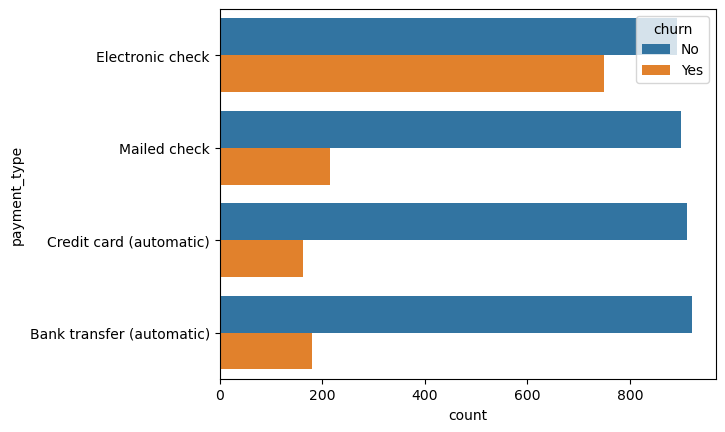

In [38]:
payment_plot(train, 'payment_type', 'churn')

In [47]:
def monthly_charges_hist(df, target, column, color1, color2, alpha1, alpha2, edgecolor, label1, label2, xlabel, ylabel, title):
    churn = df[df[target] == 'Yes'][column]
    not_churned = df[df[target] == 'No'][column]
    plt.hist(x = churn, color = 'blue', alpha = .5, edgecolor = 'black', label = 'churned')
    plt.hist(x = not_churned, color = 'red', alpha = .1, edgecolor = 'black', label = 'not churned')
    plt.legend(loc = 'upper right')
    plt.xlabel('Monthly Charges')
    plt.ylabel('Number of Customers')
    plt.title('Churn Based on Monthly Charges')
    plt.show()

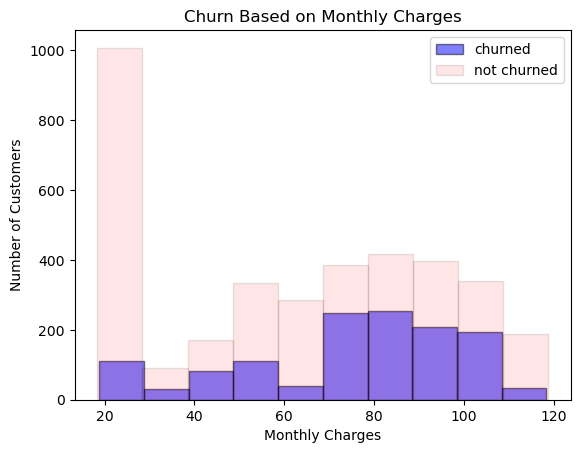

In [48]:
monthly_charges_hist(train, 'churn', 'monthly_charges', 'red', 'blue', 
                      .5, .1, 'black', 'churned', 'did not churn', 'Monthly Charges', 
                     'Amount of Customers', 'Churn Based on Monthly Charges')

In [49]:
def change_int(df, parameter):
    df[parameter] = np.where(df[parameter] == 'Yes', 1, 0)

In [52]:
change_int(telco, 'dependents')

In [50]:
def drop_cols(df, drop1, drop2, ax):
    df = df.drop([drop1, drop2], axis = ax)
    return df

In [53]:
telco2 = drop_cols(telco, 'contract_type', 'payment_type', 1)

In [54]:
train, validate, test, X_train, y_train, X_val, y_val, X_test, y_test = split_data(telco2, 'churn')

In [55]:
def baseline(df, target):
    baseline = len(df[df[target] == 'No'])/ len(df)
    return baseline

In [56]:
baseline(telco, 'churn')

0.7346301292063041

In [78]:
def dec_tree(x, y, depth):
    train_tree = DecisionTreeClassifier(max_depth= depth, random_state=42)
    train_tree.fit(x, y)
    plt.figure(figsize=(13, 7))
    plot_tree(train_tree, feature_names=x.columns, class_names=train_tree.classes_, rounded=True)

    return train_tree

DecisionTreeClassifier(max_depth=6, random_state=42)

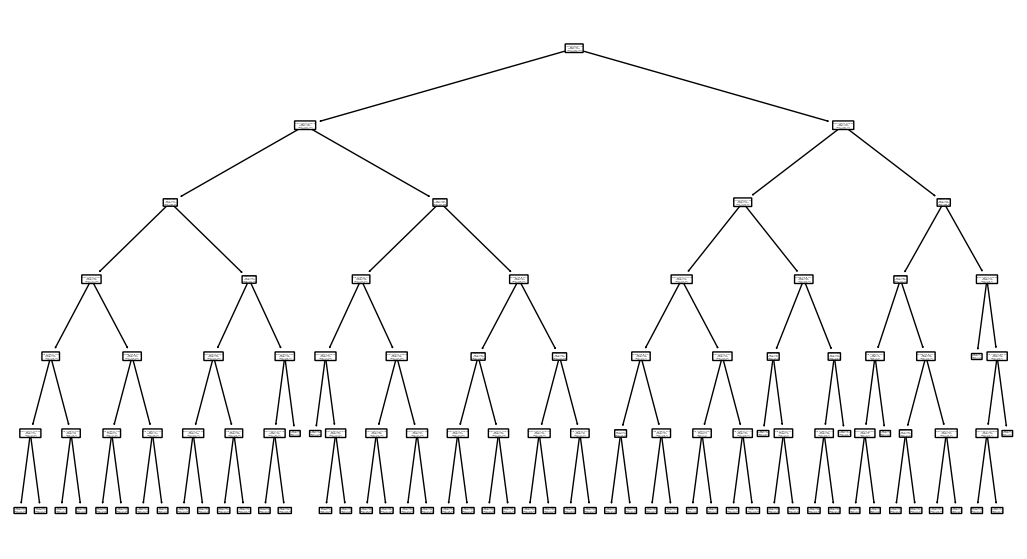

In [79]:
dec_tree(X_train, y_train, 6)

In [59]:
def tree_score(x,y,depth):
    train_tree = DecisionTreeClassifier(max_depth= depth, random_state=77)
    train_tree.fit(X_train, y_train)
    train_tree.score(x,y)
    return train_tree.score(x,y)

In [60]:
tree_score(X_test, y_test, 7)

0.771050141911069

In [80]:
def tree_matrix(x, y, depth):
    train_tree = DecisionTreeClassifier(max_depth= depth, random_state=42)
    train_tree.fit(x, y)
    pred = train_tree.predict(x)
    labels = sorted(y.unique())
    df = pd.DataFrame(confusion_matrix(y, pred), index=labels, columns=labels)
    return df

In [81]:
tree_matrix(X_train, y_train, 6)

,No,Yes
No,3288,334
Yes,608,700


In [82]:
def tree_report(x, y, depth):
    train_tree = DecisionTreeClassifier(max_depth= depth, random_state=42)
    train_tree.fit(x, y)
    pred = train_tree.predict(x)
    print(classification_report(y, pred))

In [83]:
tree_report(X_train, y_train, 6)

              precision    recall  f1-score   support

          No       0.84      0.91      0.87      3622
         Yes       0.68      0.54      0.60      1308

    accuracy                           0.81      4930
   macro avg       0.76      0.72      0.74      4930
weighted avg       0.80      0.81      0.80      4930



In [84]:
def rfc_score(x, y, depth):
    rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=depth, 
                            random_state=42)
    rf.fit(X_train, y_train)
    pred = rf.predict(x)
    rf.score(x, y)
    return rf.score(x, y)

In [85]:
rfc_score(X_train, y_train, 7)

0.8188640973630832

In [86]:
def rfc_matrix(x, y, depth):
    rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=depth, 
                            random_state=77)
    rf.fit(x, y)
    pred = rf.predict(x)
    labels = sorted(y.unique())
    df = pd.DataFrame(confusion_matrix(y, pred), index=labels, columns=labels)
    return df

In [77]:
rfc_matrix(X_train, y_train, 6)

,No,Yes
No,3327,295
Yes,639,669


In [88]:
def rfc_report(x, y, depth):
    rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=depth, 
                            random_state=42)
    rf.fit(x, y)
    pred = rf.predict(x)
    print(classification_report(y, pred))

In [89]:
rfc_report(X_train, y_train, 6)

              precision    recall  f1-score   support

          No       0.84      0.92      0.88      3622
         Yes       0.70      0.52      0.60      1308

    accuracy                           0.81      4930
   macro avg       0.77      0.72      0.74      4930
weighted avg       0.80      0.81      0.80      4930



In [91]:
def log_reg_score(x, y, c):
    logit = LogisticRegression(C= c, random_state=42, intercept_scaling=1, solver='lbfgs')
    logit.fit(x, y)
    pred = logit.predict(x)
    logit.score(x, y)
    return logit.score(x, y)

In [92]:
log_reg_score(X_train, y_train, 1)

0.7943204868154158

In [93]:
def log_matrix(x, y, c):
    logit = LogisticRegression(C= c, random_state=42, intercept_scaling=1, solver='lbfgs')
    logit.fit(x, y)
    pred = logit.predict(x)
    labels = sorted(y.unique())
    df = pd.DataFrame(confusion_matrix(y, pred), index=labels, columns=labels)
    return df

In [94]:
log_matrix(X_train, y_train, 1)

,No,Yes
No,3265,357
Yes,657,651


In [97]:
def log_report(x, y, c):
    logit = LogisticRegression(C= c, random_state=42, intercept_scaling=1, solver='lbfgs')
    logit.fit(x, y)
    pred = logit.predict(x)
    print(classification_report(y, pred))

In [98]:
log_report(X_train, y_train, 1)

              precision    recall  f1-score   support

          No       0.83      0.90      0.87      3622
         Yes       0.65      0.50      0.56      1308

    accuracy                           0.79      4930
   macro avg       0.74      0.70      0.71      4930
weighted avg       0.78      0.79      0.79      4930

